In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=19e1e726acb10617bdc1dc8613e2dd8cff3da96f1cad4d5cde97b66c201d9229
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pyspark
from pyspark.sql import SparkSession


In [ ]:

# Initialize Spark
spark = SparkSession.builder.appName("Cardio_process").getOrCreate()


In [ ]:

historical_data  = spark.read.csv("cardio_train.csv", header=True, inferSchema=True)


In [ ]:
historical_data.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13|17668|     1|   158|  71.0|  110|   70

In [ ]:
historical_data.describe(['age', 'height', 'weight', 'ap_hi', 'ap_lo']).show()


+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|               age|            height|            weight|            ap_hi|             ap_lo|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|             70000|             70000|             70000|            70000|             70000|
|   mean|19468.865814285713|164.35922857142856|          74.20569|128.8172857142857| 96.63041428571428|
| stddev| 2467.251667241397| 8.210126364538075|14.395756678511347|154.0114194560919|188.47253029638918|
|    min|             10798|                55|              10.0|             -150|               -70|
|    max|             23713|               250|             200.0|            16020|             11000|
+-------+------------------+------------------+------------------+-----------------+------------------+



In [ ]:
historical_data.describe(['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']).show()

+-------+-------------------+------------------+------------------+-------------------+--------------------+------------------+
|summary|             gender|       cholesterol|              gluc|              smoke|                alco|            active|
+-------+-------------------+------------------+------------------+-------------------+--------------------+------------------+
|  count|              70000|             70000|             70000|              70000|               70000|             70000|
|   mean| 1.3495714285714286|1.3668714285714285| 1.226457142857143|0.08812857142857143|0.053771428571428574|0.8037285714285715|
| stddev|0.47683801558286265|0.6802503486993823|0.5722702766138456|0.28348381676993667| 0.22556770360410555|0.3971790635049267|
|    min|                  1|                 1|                 1|                  0|                   0|                 0|
|    max|                  2|                 3|                 3|                  1|                 

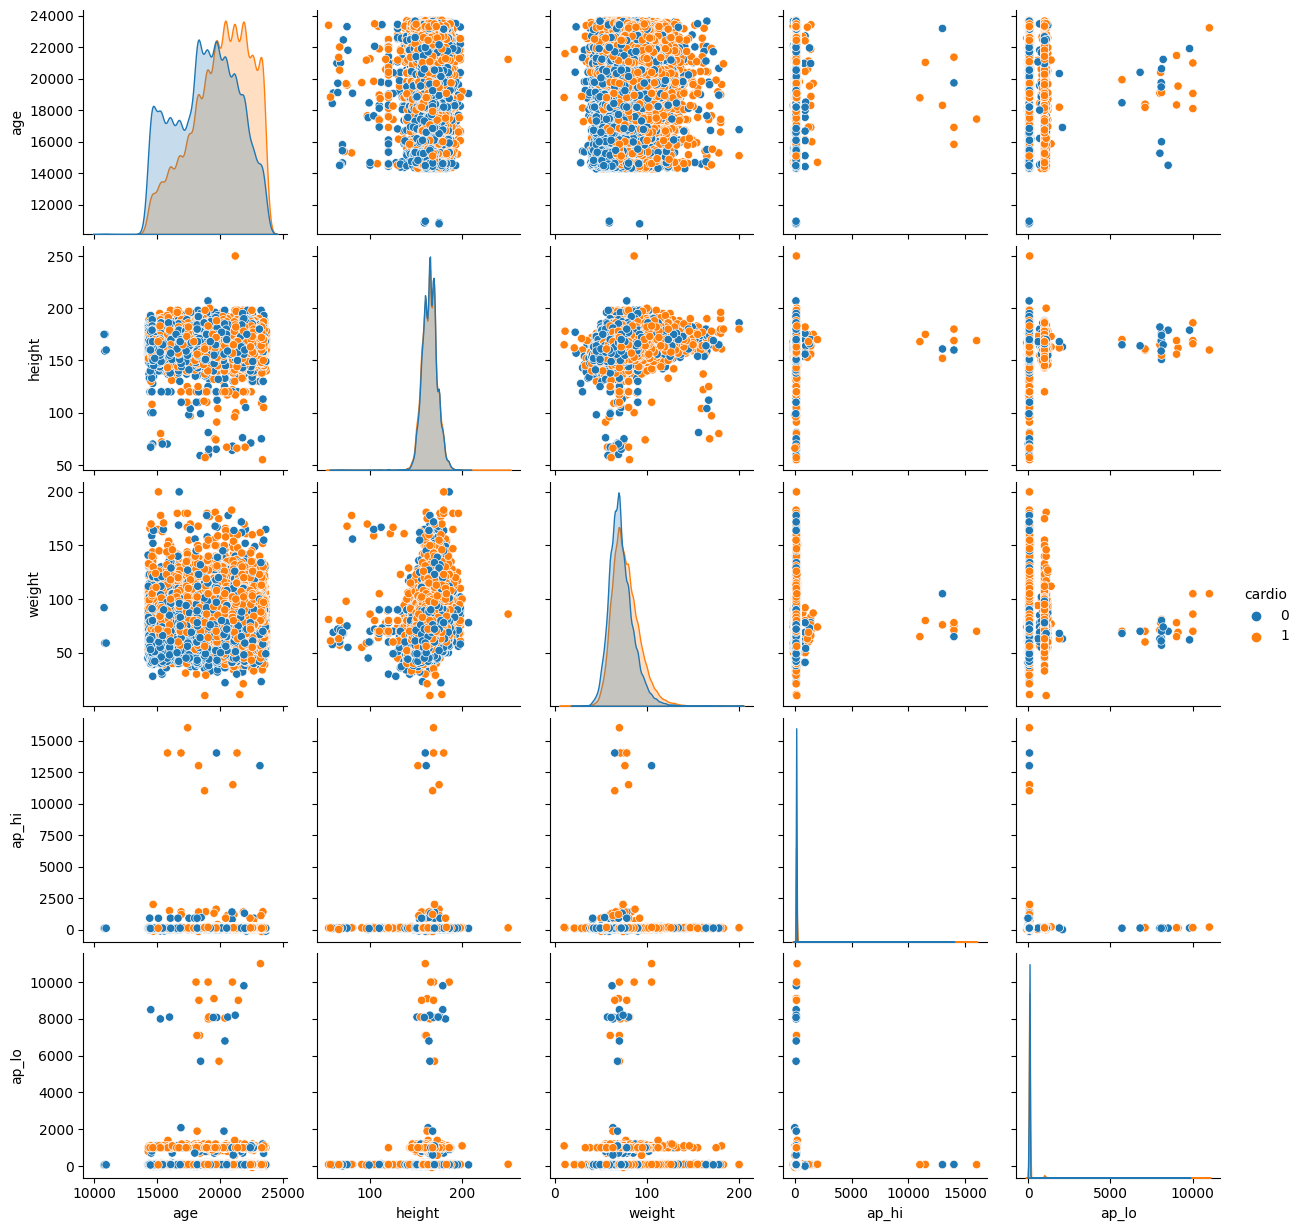

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Pairplot for numerical features
sns.pairplot(historical_data.toPandas(), vars=['age', 'height', 'weight', 'ap_hi', 'ap_lo'], hue='cardio')
plt.show()


In [ ]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Data Preprocessing
# Assuming there are no missing values in the provided dataset.

# Data Cleaning and Transformation
# We'll create a BMI feature and encode categorical features.
historical_data = historical_data.withColumn("bmi", historical_data["weight"] / ((historical_data["height"] / 100) ** 2))

historical_data.show()


+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|               bmi|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|  21.9671201814059|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.927679158448385|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.507805325987146|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 28.71047932495361|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.011176857330703|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|29.384676110696898|
|  9|22113|     1|   157|  93.0|  130|   80|  

In [ ]:
# Read the CSV file into a Pandas DataFrame
cardio_data = pd.read_csv("/content/cardio_train.csv")

# Display the first few rows of the DataFrame
print(cardio_data.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [ ]:

# Calculate the correlation matrix
correlation_matrix = cardio_data.corr()


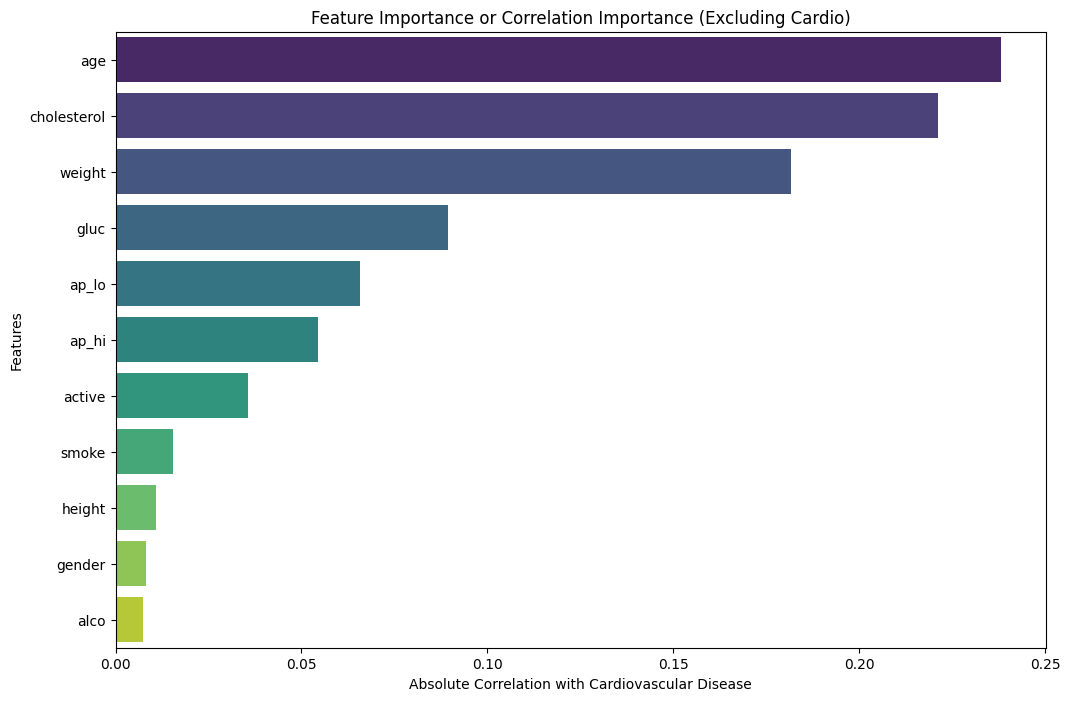

In [ ]:

# Exclude the target variable (cardio) from feature importance
feature_importance = correlation_matrix['cardio'].abs().drop(['cardio', 'id']).sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance or Correlation Importance (Excluding Cardio)')
plt.xlabel('Absolute Correlation with Cardiovascular Disease')
plt.ylabel('Features')
plt.show()

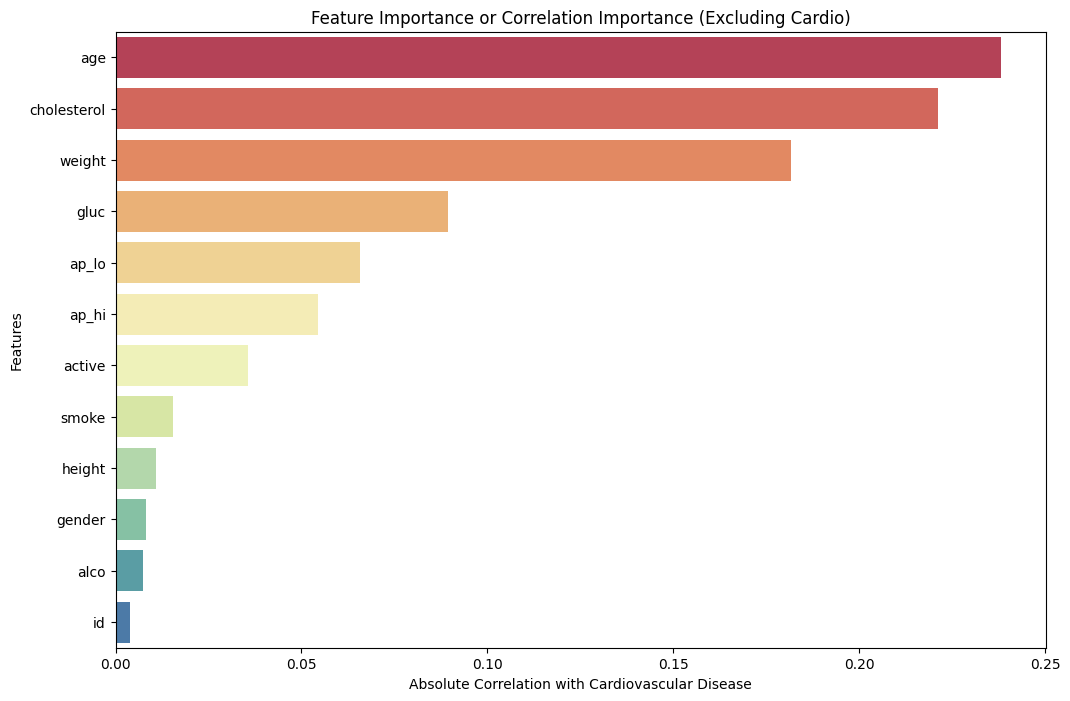

In [ ]:
# Define a color palette from red to yellow, pink, and orange
colors = sns.color_palette("Spectral", len(feature_importance))

# Plot the bar graph
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette=colors)
plt.title('Feature Importance or Correlation Importance (Excluding Cardio)')
plt.xlabel('Absolute Correlation with Cardiovascular Disease')
plt.ylabel('Features')
plt.show()


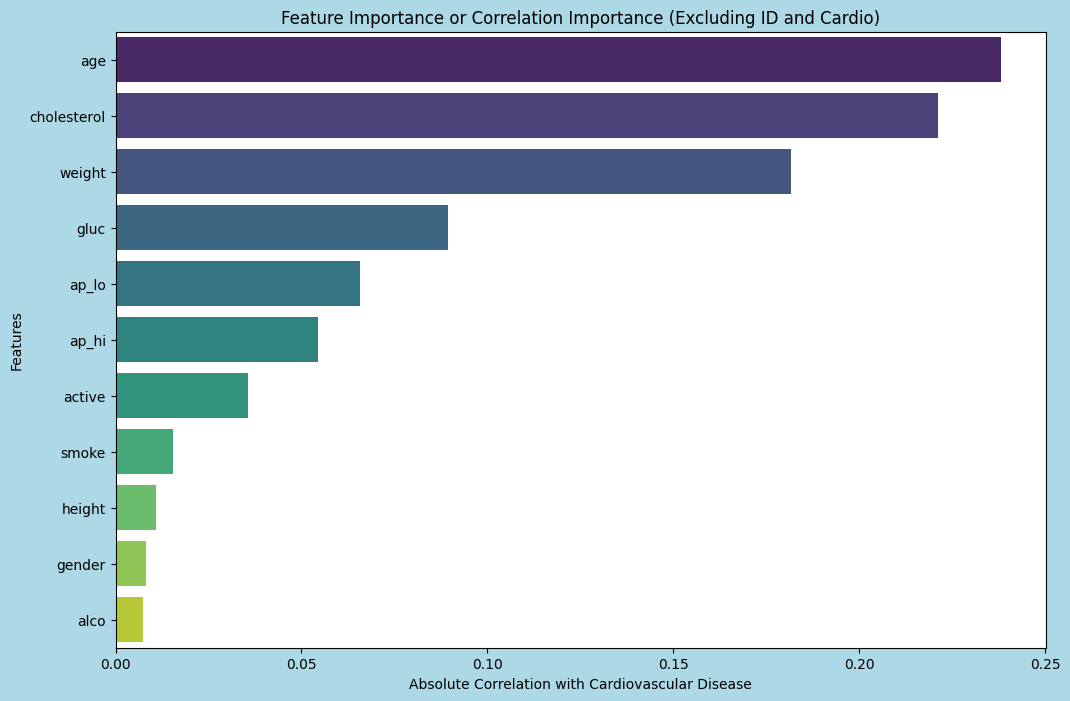

In [ ]:
# Set the background color to light blue
plt.figure(figsize=(12, 8), facecolor='lightblue')

# Plot the bar graph
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance or Correlation Importance (Excluding ID and Cardio)')
plt.xlabel('Absolute Correlation with Cardiovascular Disease')
plt.ylabel('Features')
plt.show()